## Check effect of adding Poisson Noise (with skylevel 0) in Galsim


In [1]:
import galsim
import matplotlib.pyplot as plt
import numpy as np 
import random
import copy

In [2]:
random_seed = 1314662
size = 1 # no of samples
image_size = 64        # n x n pixels
pixel_scale = 0.23     # arcsec / pixel

### Step1: Generate the Galaxy

In [3]:
# initializations
gal_flux_ = np.zeros(size)
bulge_re_ = np.zeros(size)
bulge_n_ = np.zeros(size)
# gal_q_ = np.zeros(size)
gal_beta_ = np.zeros(size)
g_1_= np.zeros(size)
g_2_= np.zeros(size)

#parameter random generations  
bulge_re = random.uniform(0.1, 0.6)         # sersic radius, unit arcsec
bulge_n = random.uniform(0.5, 6)        # sersic index

A = random.uniform(0, 0.67)    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q 
# gal_q=(1- A ) /(1+ A ) 
gal_beta = random.uniform(0, 3.14)        #  radians     
g_1 = A*np.cos(2*gal_beta)
g_2 = A*np.sin(2*gal_beta)

gal_flux = 1e5*random.uniform(.3, 4)

gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
gal = gal.withFlux(gal_flux)
gal = gal.shear(g1=g_1, g2=g_2)

# image generation of galaxy at times requires FFT that are very large, and current hardware doesn't support that
# hence iamge generation & display is disabled

# img_gal = galsim.ImageF(image_size, image_size, scale=pixel_scale)
# gal.drawImage(image=img_gal);
# plt.imshow(img_gal.array) # image without noise 

### Step2: Observe the Galaxy

### Step2a: Generate psf

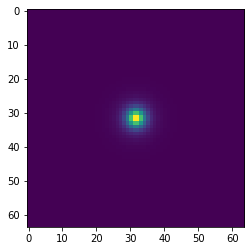

In [4]:
psf_ =  np.zeros(size)
psf_beta = 2       #moffat parameter

psf_re=random.uniform(0.5,1)         # PSF moffat scale radius in arcsec 

psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   

img_psf = galsim.ImageF(image_size, image_size, scale=pixel_scale)
psf.drawImage(image=img_psf);
plt.imshow(img_psf.array) # image of psf


### Step2b: Convolve with psf / Observe Galaxy through atmosphere & telescope

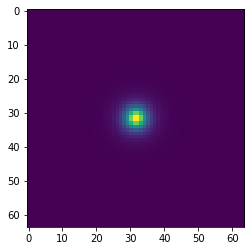

In [5]:
obs = galsim.Convolve([psf, gal])

img_obs = galsim.ImageF(image_size, image_size, scale=pixel_scale)
obs.drawImage(image=img_obs);
plt.imshow(img_obs.array) # image of observation

snr(gaussian noise): 31.63
snr(constant noise): 31.41
snr(gaussian + possion noise): 44.71


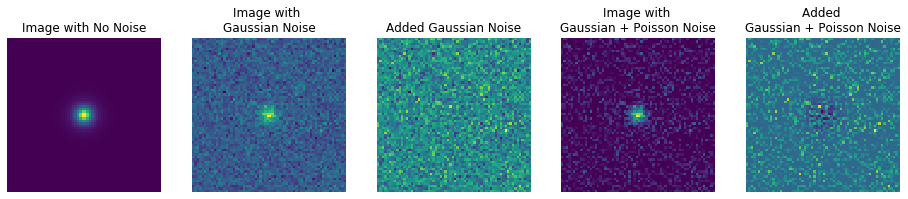

In [10]:
fig, ax = plt.subplots(1,5, figsize=(16,4))
i = 0

# 1. no noise image
obs_no_noise = copy.deepcopy(img_obs.array)
ax[i].imshow(obs_no_noise)
ax[i].set_title("Image with No Noise")
ax[i].axis("off")

img_obs_noise = galsim.ImageF(image_size, image_size, scale=pixel_scale)
obs.drawImage(image=img_obs_noise);

# 2. GaussianNoise per pixel
noise = random.randint(200,400)
img_obs_noise.addNoise(galsim.GaussianNoise(sigma=noise))
# noisemap = np.random.normal(0, noise, 64*64)  #noise map for bkgr gaussian noise 
# noisemap = noisemap.reshape((64,64))
# img_obs_noise += noisemap
snr = np.sqrt((obs_no_noise**2).sum())/np.sqrt(((img_obs_noise.array - obs_no_noise)**2).sum()/(image_size*image_size))
print("snr(gaussian noise): {0:.2f}".format(snr))

snr = np.sqrt((obs_no_noise**2).sum())/noise
print("snr(constant noise): {0:.2f}".format(snr))

i += 1
ax[i].imshow(img_obs_noise.array) # image of observation
ax[i].set_title("Image with \nGaussian Noise")
ax[i].axis("off")

# show added noise
i += 1
ax[i].imshow(img_obs_noise.array - obs_no_noise) # image of observation
ax[i].set_title("Added Gaussian Noise")
ax[i].axis("off")

# 3. add CCD noise

# The PoissonNoise class encapsulates a simple version of the 
# noise model of a normal CCD image where each pixel has Poisson noise 
# ccorresponding to the number of electrons in each pixel
img_obs_noise.addNoise(galsim.PoissonNoise(sky_level=0.))
i += 1
ax[i].imshow(img_obs_noise.array) # image of observation
ax[i].set_title("Image with \nGaussian + Poisson Noise")
ax[i].axis("off")

snr = np.sqrt((obs_no_noise**2).sum())/np.sqrt(((img_obs_noise.array - obs_no_noise)**2).sum()/(image_size*image_size))
print("snr(gaussian + possion noise): {0:.2f}".format(snr))

i += 1
ax[i].imshow(img_obs_noise.array - obs_no_noise) # image of observation
ax[i].set_title("Added \nGaussian + Poisson Noise")
ax[i].axis("off");

### Observations

1. Adding Poisson noise / CCD noise, with sky level 0, adds CCD noise. This is as per documentation:<br>
*"The PoissonNoise class encapsulates a simple version of the noise model of a normal CCD image where each pixel has Poisson noise corresponding to the number of electrons in each pixel (including an optional extra sky level).*<br>
*Note that if the image to which you are adding noise already has a sky level on it, then you should not provide the sky level here as well. The sky level here corresponds to a level that is taken to be already subtracted from the image, but that originally contributed to the addition of Poisson noise."*<br>
2. As Poisson noise for CCD per pixel can be approximated to +/- sqrt(Photons/pixel), when pixels contain only gaussian noise, it is reducing the noise level in those pixels<br>
3. Overall if we calculate the SNR before and after adding Poisson Noise, the SNR improves.<br>


**References**<br>
1. https://galsim-developers.github.io/GalSim/_build/html/noise.html
